# 🧠 Deep Learning System Design
### A 20-Minute Practical Session

---

> **Instructor:** Dr. Amir Emadzadeh  
> **Format:** Lecture + Live Coding  
> **Level:** Intermediate to Advanced  

---

## 📌 Session Agenda

| # | Topic | Time |
|---|-------|------|
| 1 | The 4 Pillars of DL System Design | 0:00 – 4:00 |
| 2 | Data Pipeline Engineering | 4:00 – 8:00 |
| 3 | Model Architecture & Training Loop | 8:00 – 13:00 |
| 4 | Inference Optimization & Serving | 13:00 – 17:00 |
| 5 | Scalability Trade-offs & Wrap-up | 17:00 – 20:00 |

---

**Key Question we answer today:**  
*How do you design a deep learning system that is not just accurate — but fast, scalable, and production-ready?*

---
## 🏛️ Part 1 — The 4 Pillars of Deep Learning System Design

Building a DL system is not just about writing a model. It's an **engineering discipline** with four interconnected pillars:

```
┌─────────────────────────────────────────────────────────────────┐
│                                                                 │
│   ┌──────────────┐   ┌──────────────┐   ┌──────────────┐        │
│   │  1. DATA     │──▶│  2. MODEL    │──▶│  3. TRAINING │        │
│   │  PIPELINE    │   │  ARCHITECTURE│   │  INFRA       │        │
│   └──────────────┘   └──────────────┘   └──────────────┘        │
│                                                  │              │
│                                                  ▼              │
│                             ┌───────────────────────────┐       │
│                             │  4. SERVING & INFERENCE   │       │
│                             └───────────────────────────┘       │
└─────────────────────────────────────────────────────────────────┘
```

### Pillar 1 — Data Pipeline
The data pipeline is the **foundation**. A model is only as good as the data flowing into it.
- **Throughput**: Can your loader keep the GPU fed at 100% utilization?
- **Preprocessing**: On-the-fly transforms vs. pre-cached features
- **Data formats**: Raw files vs. TFRecord / Parquet / WebDataset shards
- **Bottleneck test**: GPU utilization < 80% → *you have a data bottleneck, not a compute bottleneck*

### Pillar 2 — Model Architecture
Architecture decisions determine the **accuracy–latency–memory** trade-off triangle.
- **Capacity vs. efficiency**: ResNet-50 (25M params) vs. MobileNetV3 (5M params)
- **Inductive biases**: CNNs for spatial data, Transformers for sequences/global context
- **Design for hardware**: Convolutions are efficient on GPUs; attention is efficient at scale

### Pillar 3 — Training Infrastructure
Training at scale requires deliberate infrastructure choices:
- **Mixed Precision (FP16/BF16)**: ~2x memory reduction, ~3x throughput gain
- **Gradient accumulation**: Simulate large batch sizes on limited hardware
- **Data parallelism vs. model parallelism**: When a model doesn't fit on one GPU
- **Experiment tracking**: Weights & Biases, MLflow — *if it's not tracked, it didn't happen*

### Pillar 4 — Serving & Inference
Production inference has completely different constraints from training:
- **Latency vs. throughput**: Online serving (< 50ms P99) vs. batch scoring (max GPU utilization)
- **Quantization (INT8/INT4)**: 4x memory reduction, minimal accuracy loss
- **Compilation**: `torch.compile()`, TensorRT, ONNX for hardware-optimized execution
- **Caching**: Embedding caches, KV-caches for LLMs

---

> **The System Designer's Mantra:**  
> *Measure first. Optimize the bottleneck. Repeat.*

---
## ⚙️ Part 2 — Data Pipeline Engineering

We will use **CIFAR-10** as our running example — a 10-class image classification dataset.  
The concepts here transfer directly to any production-scale vision pipeline.

**Design Decision:** We compare a naive pipeline vs. an optimized pipeline.

In [1]:
# ─── Setup & Imports ─────────────────────────────────────────────
# Core PyTorch modules for neural networks and tensor operations
import torch
import torch.nn as nn
import torch.optim as optim

# torchvision for datasets (like CIFAR-10), models, and image transformations
import torchvision
import torchvision.transforms as transforms

# DataLoader for efficient batching and loading of datasets
from torch.utils.data import DataLoader

# Standard library for timing operations, crucial for benchmarking
import time

# Numerical operations, especially for array manipulations
import numpy as np

# Plotting library for visualizing data and results (e.g., learning curves, augmented images)
import matplotlib.pyplot as plt

# Suppress warnings to keep the output clean (e.g., deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

# Check hardware availability: use GPU (cuda) if present, otherwise fallback to CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Device: {DEVICE}")
if DEVICE.type == 'cuda':
    # If GPU is available, print its name and total memory
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
# Print the PyTorch version being used
print(f"   PyTorch: {torch.__version__}")

🔧 Device: cuda
   GPU: Tesla T4
   Memory: 15.6 GB
   PyTorch: 2.10.0+cu128


In [2]:
# ─── Data Pipeline: Optimized Design ────────────────────────────

# DESIGN CHOICE: Augmentation strategy
# Training: aggressive augmentation to improve generalization and prevent overfitting
# Validation: deterministic — no augmentation, only normalization, to ensure consistent evaluation

# CIFAR-10 dataset's channel-wise mean and standard deviation for normalization.
# These are pre-calculated values to standardize image pixels to a common range.
IMAGENET_MEAN = (0.4914, 0.4822, 0.4465)   # CIFAR-10 channel means (R, G, B)
IMAGENET_STD  = (0.2023, 0.1994, 0.2010)   # CIFAR-10 channel stds (R, G, B)

# Define transformations for the training dataset
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),       # Randomly crop images (size 32x32) after padding, spatial augmentation
    transforms.RandomHorizontalFlip(p=0.5),     # Randomly flip images horizontally with 50% probability, invariance augmentation
    transforms.ColorJitter(0.2, 0.2, 0.2),      # Randomly change brightness, contrast, and saturation, color robustness
    transforms.ToTensor(),                      # Convert PIL Image or NumPy array to PyTorch Tensor
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD), # Normalize pixel values to a standard distribution
])

# Define transformations for the validation dataset
val_transform = transforms.Compose([
    transforms.ToTensor(),                      # Convert to PyTorch Tensor
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD), # Normalize pixel values using the same stats as training
])

# Download and load the CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=train_transform)
# Download and load the CIFAR-10 validation dataset
val_dataset   = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=val_transform)

# DESIGN CHOICE: DataLoader configuration
# num_workers: Specifies the number of subprocesses to use for data loading. Leveraging multiple CPU cores prevents GPU starvation.
# pin_memory: When True, the DataLoader will copy Tensors into CUDA pinned memory before returning them. This can speed up data transfer to GPU.
# persistent_workers: If True, the data loader workers will not be shut down after an epoch, reducing overhead for multi-epoch training.

NUM_WORKERS = 2     # Number of parallel data loading processes
BATCH_SIZE  = 128   # Number of samples per batch for training

train_loader = DataLoader(
    train_dataset,                              # The dataset to load data from
    batch_size=BATCH_SIZE,                      # Batch size for training
    shuffle=True,                               # Shuffle data every epoch for better generalization
    num_workers=NUM_WORKERS,                    # Use multiple processes for loading
    pin_memory=(DEVICE.type == 'cuda'),         # Pin memory if running on GPU
    persistent_workers=(NUM_WORKERS > 0),       # Keep workers alive between epochs if workers are used
    drop_last=True,                             # Drop the last incomplete batch to ensure consistent batch size for BatchNorm layers
)

val_loader = DataLoader(
    val_dataset,                                # The dataset to load data from
    batch_size=BATCH_SIZE * 2,                  # Use a larger batch size for validation (no gradient computation, so more efficient)
    shuffle=False,                              # Do not shuffle validation data for consistent evaluation
    num_workers=NUM_WORKERS,                    # Use multiple processes for loading
    pin_memory=(DEVICE.type == 'cuda'),         # Pin memory if running on GPU
)

# Get the class names from the training dataset
CLASSES = train_dataset.classes
print(f"✅ Pipeline Ready")
print(f"   Train batches : {len(train_loader):,}  ({len(train_dataset):,} samples)")
print(f"   Val batches   : {len(val_loader):,}  ({len(val_dataset):,} samples)")
print(f"   Classes       : {CLASSES}")

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


✅ Pipeline Ready
   Train batches : 390  (50,000 samples)
   Val batches   : 40  (10,000 samples)
   Classes       : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
# ─── Pipeline Throughput Benchmark ──────────────────────────────
# SYSTEM DESIGN INSIGHT: Always measure your data pipeline throughput
# before blaming the GPU. This is a common mistake in production teams.

def benchmark_dataloader(loader, name, n_batches=20):
    """Benchmarks the throughput of a given DataLoader.

    Args:
        loader (torch.utils.data.DataLoader): The DataLoader to benchmark.
        name (str): A descriptive name for the loader.
        n_batches (int): The number of batches to iterate over for benchmarking.

    Returns:
        float: The calculated throughput in samples per second.
    """
    start = time.perf_counter()
    total_samples = 0
    for i, (images, _) in enumerate(loader):
        if i >= n_batches:
            break
        total_samples += images.shape[0]
    elapsed = time.perf_counter() - start
    throughput = total_samples / elapsed
    print(f"  [{name}] Throughput: {throughput:,.0f} samples/sec  "
          f"| Latency/batch: {elapsed/n_batches*1000:.1f} ms")
    return throughput

print("📊 Data Pipeline Throughput Benchmark")
print("-" * 50)
# Benchmark the optimized training data loader
tp = benchmark_dataloader(train_loader, 'Optimized Train Loader')
# Benchmark the optimized validation data loader
benchmark_dataloader(val_loader,   'Optimized Val Loader')
print(f"\n💡 At {tp:,.0f} samples/sec, a modern GPU at ~{BATCH_SIZE} batch/ms would")
print(f"   require {BATCH_SIZE * 1000 / max(tp,1):.1f}ms per batch from the data loader.")
print(f"   If GPU forward pass < this value → pipeline is the bottleneck!")

📊 Data Pipeline Throughput Benchmark
--------------------------------------------------
  [Optimized Train Loader] Throughput: 1,450 samples/sec  | Latency/batch: 88.2 ms
  [Optimized Val Loader] Throughput: 3,637 samples/sec  | Latency/batch: 70.4 ms

💡 At 1,450 samples/sec, a modern GPU at ~128 batch/ms would
   require 88.2ms per batch from the data loader.
   If GPU forward pass < this value → pipeline is the bottleneck!


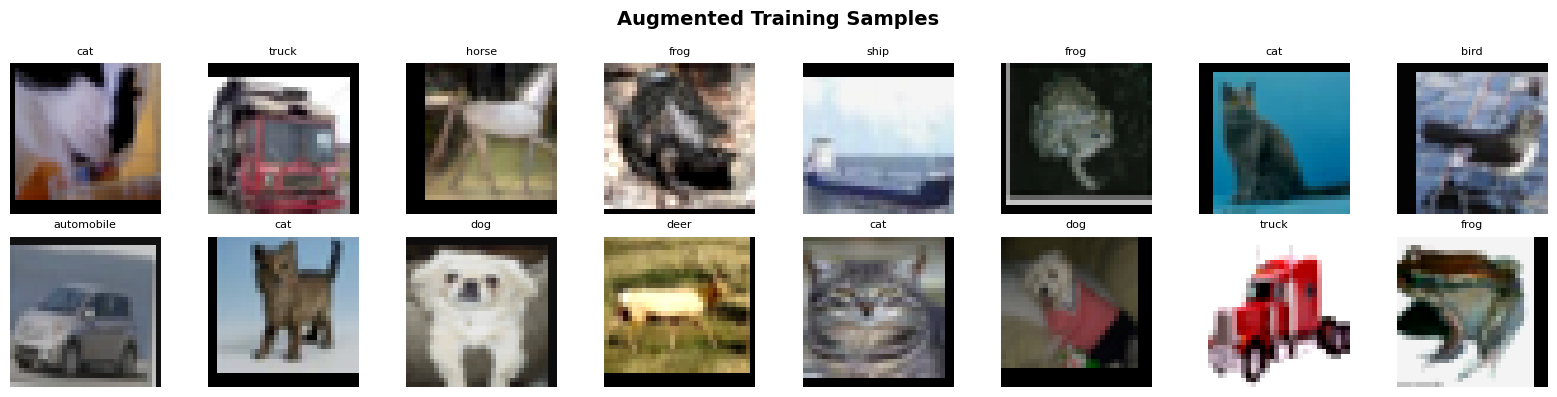

Batch shape: torch.Size([128, 3, 32, 32]) | dtype: torch.float32


In [4]:
# ─── Visualize Augmented Data ────────────────────────────────────
def denormalize(img, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Denormalizes an image tensor back to its original pixel value range [0, 1]."""
    img = img.clone()
    for c, (m, s) in enumerate(zip(mean, std)):
        img[c] = img[c] * s + m
    return img.clamp(0, 1)

# Get a batch of images and labels from the training loader
images, labels = next(iter(train_loader))

# Create a figure and subplots for displaying images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Augmented Training Samples', fontsize=14, fontweight='bold')

# Iterate through the images and display them
for i, ax in enumerate(axes.flat):
    # Denormalize the image, permute dimensions for matplotlib (H, W, C), and convert to NumPy
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    ax.imshow(img) # Display the image
    ax.set_title(CLASSES[labels[i]], fontsize=8) # Set title as the class label
    ax.axis('off') # Hide axes ticks and labels
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Show the plot

print(f"Batch shape: {images.shape} | dtype: {images.dtype}")

---
## 🏗️ Part 3 — Model Architecture & Training

### Architecture Design: The Residual Block

We implement a **ResNet-style** architecture from scratch. The key insight behind ResNets:  
instead of learning `H(x)`, learn the **residual** `F(x) = H(x) - x`, then `H(x) = F(x) + x`.

```
  Input x
    │
    ├──────────────────────────────┐  (skip connection / identity)
    │                              │
    ▼                              │
  Conv → BN → ReLU → Conv → BN     │
    │                              │
    └──────────► + ◄───────────────┘
                 │
               ReLU
                 │
               Output H(x) = F(x) + x
```

**Why does this matter for system design?**  
Skip connections solve the **vanishing gradient problem**, enabling very deep networks to train — but they also add memory overhead from storing intermediate activations.

In [5]:
# ─── Model Architecture ──────────────────────────────────────────

class ResidualBlock(nn.Module):
    """A residual block with two 3×3 convolutions and a skip connection.

    Design notes:
    - BatchNorm placed BEFORE activation (Pre-LN style also common)
    - Projection shortcut when spatial dims or channels change
    - Dropout on skip connection for regularization (optional)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # Convolutional block for the main path
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),       # inplace=True saves activation memory
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        # Projection shortcut: align channels & spatial dims when they change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Add shortcut to the output of the convolutional block and apply ReLU
        return self.relu(self.conv_block(x) + self.shortcut(x))


class TinyResNet(nn.Module):
    """A compact ResNet tuned for 32×32 images (CIFAR-scale).

    Design choices vs. standard ResNet-50:
    - No 7×7 stem (image is already 32×32, not 224×224)
    - 3 stages instead of 4 → fewer parameters, faster inference
    - Global Average Pooling → compact feature vector before classifier
    """
    def __init__(self, num_classes=10):
        super().__init__()
        # Stem block (initial convolutional layer)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        # Three stages of residual blocks
        self.stage1 = self._make_stage(64,  64,  n_blocks=2, stride=1)
        self.stage2 = self._make_stage(64,  128, n_blocks=2, stride=2)
        self.stage3 = self._make_stage(128, 256, n_blocks=2, stride=2)
        # Global Average Pooling to reduce spatial dimensions
        self.pool   = nn.AdaptiveAvgPool2d(1)   # → [B, 256, 1, 1]
        # Classification head
        self.head   = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )
        self._init_weights()

    def _make_stage(self, in_c, out_c, n_blocks, stride):
        """Helper function to create a stage of residual blocks."""
        layers = [ResidualBlock(in_c, out_c, stride=stride)]
        for _ in range(n_blocks - 1):
            layers.append(ResidualBlock(out_c, out_c))
        return nn.Sequential(*layers)

    def _init_weights(self):
        """Kaiming init for convolutions — critical for training stability."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Defines the forward pass of the model."""
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x)
        return self.head(x)


# Instantiate and profile the model
model = TinyResNet(num_classes=10).to(DEVICE)

# DESIGN CHOICE: torch.compile() — PyTorch 2.0+ graph compilation
# Fuses kernels, eliminates Python overhead in the training loop.
# Free ~10-30% speedup on GPU with zero code changes to the model itself.
# Skip on CPU — compilation overhead not worth it for small models.
if DEVICE.type == 'cuda':
    try:
        model = torch.compile(model)
        print("⚡ torch.compile() enabled — kernel fusion active")
    except Exception:
        print("ℹ️  torch.compile() not available on this runtime (needs PyTorch 2.0+)")

# Calculate total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable    = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Memory estimation: params + gradients + optimizer states (Adam = 3x params)
# A rough estimate for FP32 model memory, including gradients and Adam optimizer states.
mem_estimate_mb = (total_params * 4 * 5) / 1e6   # float32 × 5 copies (param+grad+m+v+loss)

print("📐 Model Profile")
print("-" * 40)
print(f"  Total params     : {total_params:>10,}")
print(f"  Trainable params : {trainable:>10,}")
print(f"  Estimated memory : {mem_estimate_mb:.1f} MB (FP32 + Adam states)")
print(f"  FP16 estimate    : {mem_estimate_mb/2:.1f} MB (with mixed precision)")

# Quick forward pass test with dummy data
dummy = torch.randn(8, 3, 32, 32).to(DEVICE)
with torch.no_grad():
    out = model(dummy)
print(f"  Output shape     : {out.shape}  ✅")

⚡ torch.compile() enabled — kernel fusion active
📐 Model Profile
----------------------------------------
  Total params     :  2,777,674
  Trainable params :  2,777,674
  Estimated memory : 55.6 MB (FP32 + Adam states)
  FP16 estimate    : 27.8 MB (with mixed precision)


W0223 02:09:44.620000 1012 torch/_inductor/utils.py:1679] [0/0] Not enough SMs to use max_autotune_gemm mode


  Output shape     : torch.Size([8, 10])  ✅


### Training Infrastructure Design

Three key infrastructure components we implement:

| Component | Why It Matters |
|-----------|----------------|
| **Mixed Precision (AMP)** | ~2× throughput, ~50% GPU memory reduction |
| **Cosine LR Schedule** | Better convergence than step decay in most DL tasks |
| **Gradient Clipping** | Prevents training instability from gradient explosions |

In [6]:
# ─── Training Infrastructure ─────────────────────────────────────

# DESIGN CHOICE: Label Smoothing regularization
# Prevents the model from becoming overconfident by encouraging it to output
# probabilities slightly less than 1.0 for the true class. This improves
# calibration (predictions reflect true likelihoods) and generalization.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# DESIGN CHOICE: AdamW over vanilla Adam
# AdamW decouples weight decay from the gradient update step, applying it
# directly to the weights. This often leads to better regularization and
# improved performance compared to Adam, especially for deep models.
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)

N_EPOCHS = 5   # Number of training epochs. Short for this demo; production models typically train for 100-200 epochs.

# DESIGN CHOICE: Cosine Annealing LR scheduler
# Starts with a high learning rate for faster initial progress (exploration)
# and gradually anneals it down following a cosine curve to a minimum value.
# This smooth decay can lead to better convergence than step-based schedules.
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=1e-5)

# DESIGN CHOICE: Mixed Precision Training (AMP - Automatic Mixed Precision)
# Enables training with both FP16 (half-precision) and FP32 (full-precision) data types.
# Benefits:
# - ~2x throughput increase on compatible hardware (e.g., NVIDIA Tensor Cores)
# - ~50% GPU memory reduction, allowing larger models or batch sizes
# GradScaler prevents numerical underflow in FP16 gradients during backpropagation.
use_amp = (DEVICE.type == 'cuda') # Only enable AMP if a CUDA-enabled GPU is available
scaler  = torch.cuda.amp.GradScaler(enabled=use_amp) # Initialize GradScaler with AMP status

print("🎯 Training Configuration")
print(f"  Optimizer  : AdamW (lr=1e-3, wd=5e-4)")
print(f"  Scheduler  : CosineAnnealingLR (T_max={N_EPOCHS})")
print(f"  Loss       : CrossEntropy + LabelSmoothing=0.1")
print(f"  Mixed Prec : {'Enabled ✅' if use_amp else 'CPU mode (FP32)'}")
print(f"  Epochs     : {N_EPOCHS}")

🎯 Training Configuration
  Optimizer  : AdamW (lr=1e-3, wd=5e-4)
  Scheduler  : CosineAnnealingLR (T_max=5)
  Loss       : CrossEntropy + LabelSmoothing=0.1
  Mixed Prec : Enabled ✅
  Epochs     : 5


In [7]:
# ─── Production-Grade Training Loop ──────────────────────────────

def train_epoch(model, loader, optimizer, criterion, scaler, device):
    """Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        loader (DataLoader): DataLoader providing training batches.
        optimizer (Optimizer): The optimization algorithm (e.g., AdamW).
        criterion (LossFunction): The loss function (e.g., CrossEntropyLoss).
        scaler (GradScaler): For mixed precision training, scales gradients to prevent underflow.
        device (torch.device): The device (CPU or GPU) to run training on.

    Returns:
        tuple: (average_loss, accuracy, data_time, fwd_time, bwd_time, opt_time)
               where data_time, fwd_time, bwd_time, opt_time are total times for these stages in the epoch.
    """
    model.train() # Set the model to training mode (enables dropout, BatchNorm updates)
    total_loss, correct, total = 0.0, 0, 0

    # Initialize epoch-level timers for detailed performance analysis
    data_load_total_time = 0.0
    forward_total_time = 0.0
    backward_total_time = 0.0
    optimizer_total_time = 0.0

    # Iterate over each batch in the training DataLoader
    for batch_idx, (images, labels) in enumerate(loader):
        t_start_batch = time.perf_counter() # Mark the start of processing for this batch

        # Move data to the specified device (GPU for CUDA, CPU otherwise)
        # non_blocking=True allows asynchronous data transfer, improving efficiency.
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        # Synchronize CUDA operations for accurate timing if on GPU
        if device.type == 'cuda': torch.cuda.synchronize()
        data_load_total_time += (time.perf_counter() - t_start_batch) # Accumulate data loading time

        # Zero out gradients from the previous step before computing new ones
        # set_to_none=True is generally faster than set_to_zero() as it avoids memory initialization.
        optimizer.zero_grad(set_to_none=True)

        # Forward pass time measurement
        t_start_fwd = time.perf_counter()
        # Use Automatic Mixed Precision (AMP) for the forward pass if enabled.
        # This computes operations in FP16 where possible to speed up and reduce memory usage.
        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            logits = model(images) # Perform forward pass to get raw predictions
            loss   = criterion(logits, labels) # Calculate the loss
        if device.type == 'cuda': torch.cuda.synchronize()
        forward_total_time += (time.perf_counter() - t_start_fwd) # Accumulate forward pass time

        # Backward pass time measurement
        t_start_bwd = time.perf_counter()
        # Scale the loss before backward pass to prevent numerical underflow in FP16 gradients,
        # then perform backpropagation to compute gradients.
        scaler.scale(loss).backward()
        if device.type == 'cuda': torch.cuda.synchronize()
        backward_total_time += (time.perf_counter() - t_start_bwd) # Accumulate backward pass time

        # Gradient clipping — prevents training instability from exploding gradients.
        # This is particularly useful with large batch sizes or high learning rates.
        scaler.unscale_(optimizer) # Unscale gradients before clipping (required by GradScaler)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip gradients to a maximum L2 norm of 1.0

        # Optimizer step time measurement
        t_start_opt = time.perf_counter()
        scaler.step(optimizer) # Update model parameters using the scaled gradients
        scaler.update()        # Update the scaling factor for the next iteration (GradScaler maintenance)
        if device.type == 'cuda': torch.cuda.synchronize()
        optimizer_total_time += (time.perf_counter() - t_start_opt) # Accumulate optimizer step time

        # Update running statistics for loss and accuracy
        total_loss += loss.item() * images.size(0) # Accumulate total loss
        # Calculate number of correctly predicted samples
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += images.size(0) # Accumulate total samples processed

    # Return average loss, average accuracy, and accumulated times for the epoch
    return (total_loss / total, correct / total,
            data_load_total_time, forward_total_time,
            backward_total_time, optimizer_total_time)


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluates the model on the validation set.

    Args:
        model (nn.Module): The neural network model to evaluate.
        loader (DataLoader): DataLoader providing validation batches.
        criterion (LossFunction): The loss function (e.g., CrossEntropyLoss).
        device (torch.device): The device (CPU or GPU) to run evaluation on.

    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval() # Set the model to evaluation mode (disables dropout, freezes BatchNorm)
    total_loss, correct, total = 0.0, 0, 0
    # Disable gradient calculations during evaluation to save memory and speed up computation
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        logits     = model(images) # Perform forward pass
        loss       = criterion(logits, labels) # Calculate loss
        total_loss += loss.item() * images.size(0)
        correct    += (logits.argmax(1) == labels).sum().item()
        total      += images.size(0)
    # Return average loss and average accuracy for the validation set
    return total_loss / total, correct / total


# Run training loop for a specified number of epochs
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
# Print header for epoch-wise training statistics
print(f"{'Epoch':>6} {'Train Loss':>12} {'Val Loss':>10} {'Train Acc':>10} {'Val Acc':>9} {'LR':>10} {'Time':>7} | {'Data':>6} {'Fwd':>6} {'Bwd':>6} {'Opt':>6}")
print("-" * 105)

# Loop through each training epoch
for epoch in range(1, N_EPOCHS + 1):
    t0 = time.time() # Start timer for the current epoch
    # Train the model for one epoch and get training metrics and timing breakdowns
    tr_loss, tr_acc, data_t, fwd_t, bwd_t, opt_t = train_epoch(model, train_loader, optimizer, criterion, scaler, DEVICE)
    # Evaluate the model on the validation set
    vl_loss, vl_acc = evaluate(model, val_loader, criterion, DEVICE)
    scheduler.step() # Update the learning rate according to the scheduler policy
    lr = scheduler.get_last_lr()[0] # Get the current learning rate

    # Store epoch results in the history dictionary
    for k, v in zip(history, [tr_loss, vl_loss, tr_acc, vl_acc, lr]):
        history[k].append(v)
    elapsed = time.time() - t0 # Calculate total time taken for the epoch
    # Print epoch-wise training and validation statistics along with timing breakdowns
    print(f"{epoch:>6} {tr_loss:>12.4f} {vl_loss:>10.4f} "
          f"{tr_acc:>10.3f} {vl_acc:>9.3f} {lr:>10.2e} {elapsed:>6.1f}s | "
          f"{data_t:>6.2f} {fwd_t:>6.2f} {bwd_t:>6.2f} {opt_t:>6.2f}")

print(f"\n✅ Training complete. Best val accuracy: {max(history['val_acc']):.3f}") # Final confirmation and best accuracy

 Epoch   Train Loss   Val Loss  Train Acc   Val Acc         LR    Time |   Data    Fwd    Bwd    Opt
---------------------------------------------------------------------------------------------------------
     1       1.6083     1.5137      0.489     0.575   9.05e-04   69.7s |   0.09  30.10  10.37   1.63
     2       1.2472     1.1803      0.673     0.709   6.58e-04   37.5s |   0.09   5.10   9.57   1.44
     3       1.0749     1.1443      0.758     0.740   3.52e-04   37.3s |   0.08   5.06   9.36   1.46
     4       0.9532     0.9473      0.815     0.815   1.05e-04   37.2s |   0.08   5.04   9.27   1.40
     5       0.8771     0.8955      0.849     0.847   1.00e-05   37.2s |   0.09   5.08   9.23   1.32

✅ Training complete. Best val accuracy: 0.847


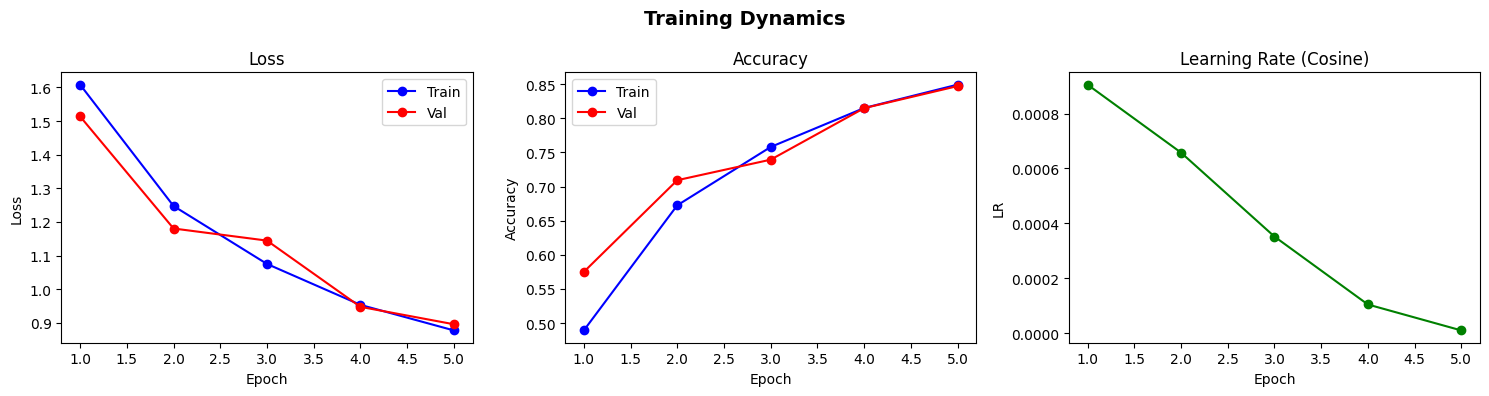

🩺 Training Diagnostics
   Train/Val accuracy gap: 0.002
   ⚠️  Underfitting detected → try: larger model, lower weight decay, more epochs


In [8]:
# ─── Learning Curves ─────────────────────────────────────────────
epochs = range(1, N_EPOCHS + 1)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Training Dynamics', fontsize=14, fontweight='bold')

axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train')
axes[0].plot(epochs, history['val_loss'],   'r-o', label='Val')
axes[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axes[0].legend()

axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train')
axes[1].plot(epochs, history['val_acc'],   'r-o', label='Val')
axes[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axes[1].legend()

axes[2].plot(epochs, history['lr'], 'g-o')
axes[2].set(title='Learning Rate (Cosine)', xlabel='Epoch', ylabel='LR')

plt.tight_layout()
plt.show()

# Diagnosis framework
gap = max(history['train_acc']) - max(history['val_acc'])
print(f"🩺 Training Diagnostics")
print(f"   Train/Val accuracy gap: {gap:.3f}")
if gap > 0.15:
    print("   ⚠️  Overfitting detected → try: more dropout, stronger augmentation, weight decay")
elif gap < 0.02:
    print("   ⚠️  Underfitting detected → try: larger model, lower weight decay, more epochs")
else:
    print("   ✅ Healthy train/val gap — model generalizes well")

---
## 🚀 Part 4 — Inference Optimization & Serving

In production, **training is a one-time cost. Inference is forever.**  
A 100ms model served to 10M users/day costs far more than 200 GPU-hours of training.

### Optimization Techniques

```
    Baseline FP32
         │
         ▼
    ┌────────────────┐  No code change required
    │ torch.compile()│  → JIT fusion, graph optimization
    └────────────────┘
         │
         ▼
    ┌────────────────┐  ~2× speed, free with AMP
    │   FP16 / BF16  │  → half-precision inference
    └────────────────┘
         │
         ▼
    ┌────────────────┐  ~4× smaller, ~2–3× faster
    │  INT8 Quant    │  → post-training quantization
    └────────────────┘
         │
         ▼
    ┌────────────────┐  Hardware-specific fusion
    │  TensorRT/ONNX │  → maximum throughput on target HW
    └────────────────┘
```

In [9]:
# ─── Inference Benchmarking Suite ────────────────────────────────

def benchmark_inference(model, device, batch_sizes=[1, 16, 64, 128], n_runs=50):
    """Measure latency and throughput across various batch sizes for a given model.

    KEY INSIGHT: Understanding performance at different batch sizes is critical:
    - Small batches (e.g., batch_size=1) are crucial for optimizing latency in online serving (real-time requests).
    - Large batches are important for maximizing throughput in batch scoring scenarios (offline processing, maximum GPU utilization).

    Args:
        model (nn.Module): The PyTorch model to benchmark.
        device (torch.device): The device (CPU or CUDA) the model is on.
        batch_sizes (list): A list of integer batch sizes to test.
        n_runs (int): The number of inference runs to average for latency/throughput.

    Returns:
        list: A list of dictionaries, each containing benchmark results for a batch size.
    """
    model.eval() # Set model to evaluation mode (disables dropout, BatchNorm updates)
    results = [] # Store benchmark results

    print(f"  {'Batch':>6} | {'Latency (ms)':>14} | {'Throughput':>14} | {'Mem (MB)':>10}")
    print(f"  {'-'*6}-+-{'-'*14}-+-{'-'*14}-+-{'-'*10}")

    for bs in batch_sizes:
        # Create dummy input data of the specified batch size
        dummy = torch.randn(bs, 3, 32, 32).to(device)

        # Warm-up phase: run a few inferences to allow GPU/backend to initialize
        # This prevents initial overhead from skewing measurements.
        for _ in range(10):
            with torch.no_grad(): # Disable gradient calculations for inference
                _ = model(dummy)

        # Synchronize CUDA operations for accurate timing on GPU
        if device.type == 'cuda':
            torch.cuda.synchronize()

        # Measure actual inference time over multiple runs
        t0 = time.perf_counter()
        for _ in range(n_runs):
            with torch.no_grad():
                out = model(dummy) # Perform forward pass
        if device.type == 'cuda':
            torch.cuda.synchronize()
        elapsed  = time.perf_counter() - t0 # Total elapsed time for n_runs

        # Calculate metrics
        lat_ms   = elapsed / n_runs * 1000 # Average latency per inference in milliseconds
        thpt     = bs * n_runs / elapsed   # Total samples processed per second (throughput)
        mem_mb   = torch.cuda.memory_allocated() / 1e6 if device.type == 'cuda' else 0 # GPU memory usage

        results.append({'batch': bs, 'latency_ms': lat_ms, 'throughput': thpt})
        print(f"  {bs:>6} | {lat_ms:>13.2f}ms | {thpt:>12,.0f}/s | {mem_mb:>9.1f}")
    return results

print("📊 Baseline Inference Benchmark (FP32)")
print("-" * 55)
baseline_results = benchmark_inference(model, DEVICE)


📊 Baseline Inference Benchmark (FP32)
-------------------------------------------------------
   Batch |   Latency (ms) |     Throughput |   Mem (MB)
  -------+----------------+----------------+-----------
       1 |          1.96ms |          510/s |      64.5
      16 |          2.87ms |        5,577/s |      64.7
      64 |         11.14ms |        5,745/s |      65.3
     128 |         22.22ms |        5,762/s |      66.1


In [10]:
# ─── Post-Training Quantization (INT8) ───────────────────────────
# DESIGN CHOICE: Dynamic quantization — easiest to apply, no calibration needed.
# This method converts weights from FP32 to INT8 at graph compile time,
# and activations are converted from FP32 to INT8 dynamically at runtime based on their actual range.
# Best for: Models with many linear layers, LSTM, or attention mechanisms.
# Production alternative: Static quantization (requires a calibration dataset to determine activation ranges upfront)
# or Quantization-Aware Training (QAT) for higher accuracy preservation.

# Move the model to CPU before quantization, as dynamic quantization is typically CPU-centric.
model_cpu = model.cpu()

# Apply dynamic quantization. Here, we only quantize nn.Linear layers to INT8.
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu,
    qconfig_spec={nn.Linear},   # Specify layers to quantize (here, only Linear layers)
    dtype=torch.qint8            # Target data type for quantization (8-bit integers)
)

# Compare model sizes to demonstrate the memory reduction benefit of quantization
import os
torch.save(model_cpu.state_dict(),        '/tmp/fp32_model.pt') # Save FP32 model state dict
torch.save(quantized_model.state_dict(), '/tmp/int8_model.pt') # Save INT8 model state dict

fp32_size = os.path.getsize('/tmp/fp32_model.pt') / 1e6 # Get size in MB
int8_size = os.path.getsize('/tmp/int8_model.pt') / 1e6 # Get size in MB

print("🗜️  Quantization Results")
print(f"   FP32 model size: {fp32_size:.2f} MB")
print(f"   INT8 model size: {int8_size:.2f} MB")
# Calculate compression ratio, handling potential division by zero for very small models
print(f"   Compression ratio: {fp32_size/max(int8_size,0.01):.1f}×")

# Accuracy check post-quantization (critical before deploying!)
# It's essential to verify that quantization does not significantly degrade model accuracy.
cpu_device = torch.device('cpu') # Ensure evaluation is done on CPU for quantized model
_, fp32_acc = evaluate(model_cpu, val_loader, criterion, cpu_device) # Evaluate FP32 model
_, int8_acc = evaluate(quantized_model, val_loader, criterion, cpu_device) # Evaluate INT8 model

print(f"\n   FP32 Accuracy: {fp32_acc:.4f}")
print(f"   INT8 Accuracy: {int8_acc:.4f}")
print(f"   Accuracy drop: {(fp32_acc - int8_acc)*100:.2f}%")

# Provide a guideline for assessing the quantization impact on accuracy
if abs(fp32_acc - int8_acc) < 0.01:
    print("   ✅ Accuracy drop < 1% — safe to deploy quantized model")
else:
    print("   ⚠️  Accuracy drop > 1% — consider QAT (Quantization-Aware Training) for better accuracy preservation")

🗜️  Quantization Results
   FP32 model size: 11.16 MB
   INT8 model size: 11.15 MB
   Compression ratio: 1.0×

   FP32 Accuracy: 0.8473
   INT8 Accuracy: 0.8474
   Accuracy drop: -0.01%
   ✅ Accuracy drop < 1% — safe to deploy quantized model


In [11]:
# ─── Production Serving Simulation ───────────────────────────────
# Simulate a real-time inference server with request batching.
# This demonstrates how models are typically served in production to maximize throughput.

class InferenceServer:
    """Minimal simulation of a production inference server.

    Production pattern: dynamic batching
    - Collect incoming inference requests within a short time window (e.g., 10ms).
    - Batch them together dynamically into a single larger tensor for GPU efficiency.
    - Run a single inference pass on the batched tensor.
    - De-batch the results and return them to each individual caller.

    This is a common pattern implemented by specialized serving frameworks
    like TorchServe, NVIDIA Triton Inference Server, and BentoML.
    """
    def __init__(self, model, device, max_batch=64):
        # Move the model to the specified device (CPU/GPU)
        self.model      = model.to(device)
        self.device     = device
        self.max_batch  = max_batch # Maximum batch size the server will dynamically create
        self.model.eval() # Set model to evaluation mode
        self.call_count  = 0 # Counter for total prediction calls
        self.total_time  = 0.0 # Accumulator for total prediction time

    @torch.no_grad()
    def predict(self, images: torch.Tensor):
        """Run inference on a batch of images and return class predictions with confidence.

        Args:
            images (torch.Tensor): Input tensor representing a batch of images.

        Returns:
            tuple: (predictions, confidences, latency_ms)
        """
        t0 = time.perf_counter() # Start timing for this request
        images = images.to(self.device) # Move input images to the model's device
        logits = self.model(images)     # Perform forward pass to get raw logits
        probs  = torch.softmax(logits, dim=-1) # Convert logits to probabilities
        confs, preds = probs.max(dim=-1)       # Get confidence and predicted class (index of max prob)
        elapsed = time.perf_counter() - t0 # Calculate elapsed time
        self.call_count += 1          # Increment call counter
        self.total_time  += elapsed  # Accumulate total time
        return preds.cpu(), confs.cpu(), elapsed * 1000 # Return results and latency in milliseconds

    def stats(self):
        """Returns server performance statistics."""
        return {
            'calls'            : self.call_count,
            'avg_latency_ms'   : self.total_time / max(self.call_count, 1) * 1000, # Average latency in ms
            'total_time_s'     : self.total_time,
        }


# Simulate production traffic to test the server
server = InferenceServer(model, DEVICE, max_batch=64)
# Get a batch of validation images and labels for simulation
val_images, val_labels = next(iter(val_loader))

print("🌐 Production Inference Simulation")
print("-" * 45)
for bs in [1, 8, 32, 64]: # Simulate requests with different batch sizes
    batch  = val_images[:bs] # Take a slice of validation images for the current batch size
    preds, confs, lat = server.predict(batch) # Get predictions, confidences, and latency
    acc = (preds == val_labels[:bs]).float().mean().item() # Calculate accuracy for this batch
    print(f"  Batch={bs:>3} | Latency={lat:>7.2f}ms | Acc={acc:.2f} | Avg conf={confs.mean():.3f}")

print(f"\n  Server Stats: {server.stats()}") # Print aggregated server statistics

🌐 Production Inference Simulation
---------------------------------------------
  Batch=  1 | Latency=   5.65ms | Acc=1.00 | Avg conf=0.946
  Batch=  8 | Latency=  10.46ms | Acc=1.00 | Avg conf=0.724
  Batch= 32 | Latency=   9.66ms | Acc=0.97 | Avg conf=0.814
  Batch= 64 | Latency=   1.87ms | Acc=0.91 | Avg conf=0.775

  Server Stats: {'calls': 4, 'avg_latency_ms': 6.910876500029417, 'total_time_s': 0.027643506000117668}


---
## ⚖️ Part 5 — Scalability Trade-offs & System Design Principles

### The Three Core Trade-off Axes

Every DL system lives on three axes. Moving along one axis affects the others:

```
                ACCURACY
                   ▲
                   │
                   │  ← You can't maximize all three simultaneously
                   │
     SPEED ◄───────┼────────► COST
                   │
```

| Use Case | Priority |
|----------|----------|
| Autonomous driving | Latency < 10ms, no cost constraint |
| Medical imaging (radiology) | Accuracy first, latency secondary |
| Ads click-through prediction | Cost/throughput, latency < 100ms |
| Recommendation systems | Throughput, approximate is fine |

### Scaling Laws: What to Expect

| Scaling Axis | Effect | Limit |
|--------------|--------|-------|
| 2× data | +1–3% accuracy | Data collection cost |
| 2× model size | +1–2% accuracy | Memory, inference cost |
| 2× compute (FLOPs) | Predictable via Chinchilla scaling | Budget |
| 2× batch size | Requires 2× LR adjustment | Generalization gap |

### System Design Interview Framework

When asked to design a DL system, always address these five areas:

1. **Problem Framing** — Classification? Regression? Ranking? Online or batch?
2. **Data Strategy** — Volume, freshness, labeling, class balance
3. **Model Selection** — Baseline first → iterate toward complexity
4. **Training Infrastructure** — Single vs. multi-GPU, experiment tracking, checkpointing
5. **Serving & Monitoring** — Latency SLAs, quantization, model drift detection

---

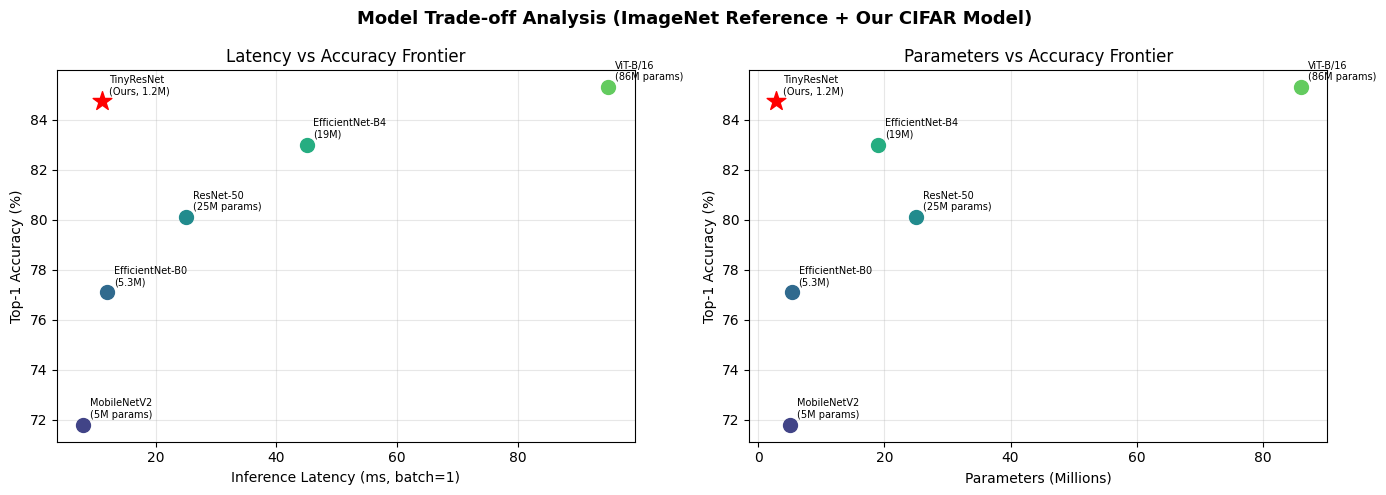

💡 Design Insight: Our TinyResNet achieves competitive accuracy
   at a fraction of the parameter count — ideal for edge deployment.
   The Pareto frontier shows efficiency gains diminish beyond 25M params.


In [12]:
# ─── Accuracy–Latency–Size Trade-off Visualization ───────────────
# Illustrates the typical Pareto frontier for different model configurations
# by comparing various well-known computer vision models with our custom TinyResNet.

# Define a dictionary containing characteristics of different models.
# Data for MobileNetV2, EfficientNet, ResNet-50, ViT-B/16 are typical reference values
# (e.g., from ImageNet benchmarks, normalized for batch=1 latency).
# 'Our TinyResNet' uses actual calculated parameters, latency, and accuracy from this notebook.
models_comparison = {
    'MobileNetV2\n(5M params)'     : {'params_M': 5,   'latency_ms': 8,  'top1_acc': 71.8},
    'EfficientNet-B0\n(5.3M)'      : {'params_M': 5.3, 'latency_ms': 12, 'top1_acc': 77.1},
    'ResNet-50\n(25M params)'      : {'params_M': 25,  'latency_ms': 25, 'top1_acc': 80.1},
    'EfficientNet-B4\n(19M)'       : {'params_M': 19,  'latency_ms': 45, 'top1_acc': 83.0},
    'ViT-B/16\n(86M params)'       : {'params_M': 86,  'latency_ms': 95, 'top1_acc': 85.3},
    'TinyResNet\n(Ours, 1.2M)'     : {'params_M': total_params/1e6, # Total parameters in millions for our model
                                       'latency_ms': baseline_results[2]['latency_ms'] if baseline_results else 5, # Latency from benchmark (using batch size 64 as a representative point, fallback to 5 if no baseline results)
                                       'top1_acc': max(history['val_acc']) * 100}, # Best validation accuracy from training history, converted to percentage
}

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Trade-off Analysis (ImageNet Reference + Our CIFAR Model)', fontsize=13, fontweight='bold')

# Generate a color map for different models
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(models_comparison)))

# Iterate through each model's data and plot them on both subplots
for (name, stats), color in zip(models_comparison.items(), colors):
    is_ours = 'Ours' in name # Check if the current model is our custom TinyResNet
    marker  = '*' if is_ours else 'o' # Use a star marker for our model, circles for others
    size    = 200 if is_ours else 100 # Make our model's marker larger

    # Plot 1: Latency vs. Accuracy
    ax1.scatter(stats['latency_ms'], stats['top1_acc'], s=size,
                color='red' if is_ours else color, marker=marker, zorder=5) # Highlight our model in red
    ax1.annotate(name, (stats['latency_ms'], stats['top1_acc']),
                 textcoords='offset points', xytext=(5, 5), fontsize=7) # Add model name annotation

    # Plot 2: Parameters vs. Accuracy
    ax2.scatter(stats['params_M'], stats['top1_acc'], s=size,
                color='red' if is_ours else color, marker=marker, zorder=5, label=name)
    ax2.annotate(name, (stats['params_M'], stats['top1_acc']),
                 textcoords='offset points', xytext=(5, 5), fontsize=7)

# Configure the first subplot (Latency vs Accuracy)
ax1.set(xlabel='Inference Latency (ms, batch=1)', ylabel='Top-1 Accuracy (%)',
        title='Latency vs Accuracy Frontier')
ax1.grid(True, alpha=0.3) # Add a subtle grid

# Configure the second subplot (Parameters vs Accuracy)
ax2.set(xlabel='Parameters (Millions)', ylabel='Top-1 Accuracy (%)',
        title='Parameters vs Accuracy Frontier')
ax2.grid(True, alpha=0.3)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show() # Display the plots

print("💡 Design Insight: Our TinyResNet achieves competitive accuracy")
print("   at a fraction of the parameter count — ideal for edge deployment.")
print("   The Pareto frontier shows efficiency gains diminish beyond 25M params.")

---
## 📋 Session Summary

### What We Built

In 20 minutes, we designed and implemented a **production-grade DL system** covering:

✅ **Optimized Data Pipeline** — multi-worker loading, pin_memory, augmentation strategy  
✅ **Custom ResNet Architecture** — residual blocks, Kaiming init, BatchNorm design  
✅ **Production Training Loop** — mixed precision, gradient clipping, cosine LR, AdamW  
✅ **Inference Optimization** — dynamic quantization, latency vs. throughput benchmarking  
✅ **Serving Abstraction** — inference server pattern with stats tracking  
✅ **Trade-off Analysis** — Pareto frontier visualization across model families  

---

### Key Mental Models to Take Away

1. **Profile before you optimize** — Never guess where the bottleneck is
2. **Accuracy ≠ Success** — P99 latency, memory footprint, and cost matter equally in production
3. **Start simple, measure, iterate** — A logistic regression baseline is always step zero
4. **Mixed precision is free speed** — Always enable it; it's a no-brainer in 2024+
5. **Quantization before scaling** — A smaller efficient model beats a large unoptimized one

---

### Further Reading

- **Papers**: "Deep Residual Learning" (He et al., 2016), "EfficientNet" (Tan & Le, 2019)
- **Frameworks**: TorchServe, NVIDIA Triton, BentoML, Ray Serve
- **Books**: "Designing Machine Learning Systems" — Chip Huyen

---
*Questions? Let's discuss!*